In [7]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from lightgbm import LGBMClassifier

# Import evaluation metrics
from sklearn.metrics import f1_score

In [8]:
data = pd.read_csv('data/train.csv')

### Data understanding

In [26]:
data.describe()

,id,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,1235.0000,1.235000e+03,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000,1235.000000
mean,617.0000,9.545004e+05,38.202186,79.574089,30.054251,4.382591,49.602429,21.388016,3.290931,3832.496356,14.612146,3.577328
std,356.6581,1.356403e+06,0.788668,29.108638,16.452066,1.937357,10.535800,26.676453,1.589195,5436.733774,193.705735,88.858953
min,0.0000,5.213990e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.500000,0.100000,0.000000,0.000000,0.000000
25%,308.5000,5.288000e+05,37.800000,53.000000,18.000000,2.000000,43.000000,6.600000,2.000000,2205.000000,0.000000,0.000000
50%,617.0000,5.297770e+05,38.200000,76.000000,28.000000,4.500000,48.000000,7.500000,3.000000,2209.000000,0.000000,0.000000
75%,925.5000,5.341450e+05,38.600000,100.000000,36.000000,6.000000,57.000000,9.100000,4.300000,3205.000000,0.000000,0.000000
max,1234.0000,5.305129e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,3112.000000,2209.000000


In [9]:
missing_values = data.isnull().sum()
columns_with_missing = missing_values[missing_values > 0]
print(columns_with_missing)

temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
rectal_exam_feces        190
abdomen                  213
abdomo_appearance         48
dtype: int64


Columns are separated in numerical, categorical and binary:

In [10]:
num_var = [column for column in data.columns if data[column].nunique() > 10]

bin_var = [column for column in data.columns if data[column].nunique() == 2]

cat_var = ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain',
           'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces',
           'abdomen', 'abdomo_appearance', 'lesion_2', 'surgery', 'age', 'surgical_lesion', 'lesion_3', 'cp_data']

#### Understanding categorical variables:

In [34]:
for column in cat_var:
    print(data[column].value_counts())
    print('-----------------------')

temp_of_extremities
cool      700
normal    324
cold      121
warm       51
Name: count, dtype: int64
-----------------------
peripheral_pulse
reduced      724
normal       429
absent        18
increased      4
Name: count, dtype: int64
-----------------------
mucous_membrane
pale_pink        284
normal_pink      260
pale_cyanotic    250
bright_red       211
dark_cyanotic    121
bright_pink       88
Name: count, dtype: int64
-----------------------
capillary_refill_time
less_3_sec    834
more_3_sec    393
3               2
Name: count, dtype: int64
-----------------------
pain
depressed       429
mild_pain       408
severe_pain     146
extreme_pain    120
alert            87
slight            1
Name: count, dtype: int64
-----------------------
peristalsis
hypomotile       664
absent           444
normal            53
hypermotile       53
distend_small      1
Name: count, dtype: int64
-----------------------
abdominal_distention
moderate    543
slight      346
none        212
severe    

### Data Preprocessing

In [11]:
data.outcome = data.outcome.map({'died': 0, 'euthanized': 1, 'lived': 2})

In [12]:
def preprocessing(dataset, le_cols, ohe_cols):
    
    # Label Encoding for binary columns
    le = LabelEncoder()    
    for col in le_cols:
        dataset[col] = le.fit_transform(dataset[col])
    
    # OneHot Encoding for category columns
    dataset = pd.get_dummies(dataset, columns = ohe_cols)
    dataset["peristalsis"] = dataset["peristalsis"].fillna("hypomotile").map({'hypermotile': 0, 'normal': 1, 'hypomotile': 2, 'absent': 3})
    dataset["abdominal_distention"] = dataset["abdominal_distention"].fillna("none").map({'none': 0, 'slight': 1, 'moderate': 2, 'severe': 3})
    dataset["nasogastric_tube"] = dataset["nasogastric_tube"].fillna("none").map({'none': 0, 'slight': 1, 'significant': 2})
    dataset["nasogastric_reflux"] = dataset["nasogastric_reflux"].fillna("none").map({'less_1_liter': 0, 'none': 1, 'more_1_liter': 2})
    dataset["rectal_exam_feces"] = dataset["rectal_exam_feces"].fillna("absent").map({'absent': 0, 'decreased': 1, 'normal': 2, 'increased': 3})
    dataset["abdomen"] = dataset["abdomen"].fillna("distend_small").map({'normal': 0, 'other': 1, 'firm': 2,'distend_small': 3, 'distend_large': 4})
    dataset["abdomo_appearance"] = dataset["abdomo_appearance"].fillna("serosanguious").map({'clear': 0, 'cloudy': 1, 'serosanguious': 2})
    dataset["pain"] = dataset["pain"].replace('slight', 'alert')
    dataset["nasogastric_reflux"] = dataset["nasogastric_reflux"].replace('slight', 'none')   
    dataset["temp_of_extremities"] = dataset["temp_of_extremities"].fillna("normal").map({'cold': 0, 'cool': 1, 'normal': 2, 'warm': 3})
    dataset["peripheral_pulse"] = dataset["peripheral_pulse"].fillna("normal").map({'absent': 0, 'reduced': 1, 'normal': 2, 'increased': 3})
    dataset["capillary_refill_time"] = dataset["capillary_refill_time"].fillna("3").map({'less_3_sec': 0, '3': 1, 'more_3_sec': 2})
    dataset["pain"] = dataset["pain"].fillna("depressed").map({'alert': 0, 'depressed': 1, 'moderate': 2, 'mild_pain': 3, 'severe_pain': 4, 'extreme_pain': 5})
    dataset["peristalsis"] = dataset["peristalsis"].replace('distend_small', 'normal')
    dataset["rectal_exam_feces"] = dataset["rectal_exam_feces"].replace('serosanguious', 'absent')

    
    return dataset 

data = preprocessing(data, le_cols = ["surgery", "age", "surgical_lesion", "cp_data"], ohe_cols = ["mucous_membrane"])


In [13]:
#Substituing nan values with the mode in the column.
def cleaning_nan(dataset):
    data_preprocessed = dataset.copy()
    cols_with_nan = dataset.drop('outcome', axis=1).columns[dataset.drop('outcome', axis=1).isna().any()].tolist()
    for feature in cols_with_nan:
        data_preprocessed[feature].fillna(data_preprocessed[feature].mode()[0], inplace=True)
    return data_preprocessed

data = cleaning_nan(data)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 887
[LightGBM] [Info] Number of data points in the train set: 1235, number of used features: 31
[LightGBM] [Info] Start training from score -1.102669
[LightGBM] [Info] Start training from score -1.593373
[LightGBM] [Info] Start training from score -0.766197


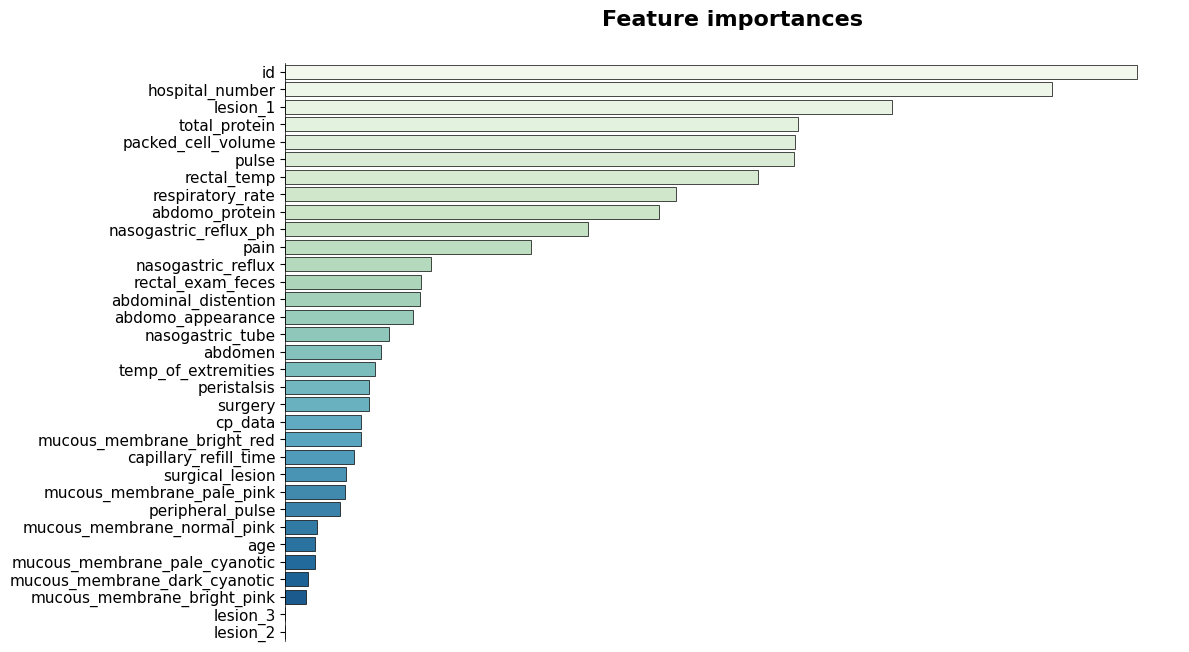

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances', size=16, y=1.05, 
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='imp', y='feature', hue='feature', linestyle="-", 
                    linewidth=0.5, edgecolor="black",palette='GnBu')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    #plt.show()


clf = LGBMClassifier(n_estimators=300,
                     max_depth=15,
                     random_state=42)
clf.fit(data.drop('outcome',axis=1), data['outcome'])

f_imp_df = pd.DataFrame({'feature': data.drop('outcome',axis=1).columns, 'imp': clf.feature_importances_})
f_imp_df.sort_values(by='imp',ascending=False,inplace=True)
f_importance_plot(f_imp_df)

### Model Training

In [93]:
best_features = f_imp_df.head(20).feature.to_list()[1:]

In [94]:
best_features

['hospital_number',
 'lesion_1',
 'pulse',
 'packed_cell_volume',
 'total_protein',
 'rectal_temp',
 'respiratory_rate',
 'abdomo_protein',
 'nasogastric_reflux_ph',
 'pain',
 'rectal_exam_feces',
 'nasogastric_reflux',
 'abdomo_appearance',
 'abdominal_distention',
 'abdomen',
 'nasogastric_tube',
 'temp_of_extremities',
 'peristalsis',
 'surgery']

In [95]:
X = data[best_features]
y = data['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score


hist_model = HistGradientBoostingClassifier(
    max_depth=4,           # Adjust the maximum depth of each tree
    max_iter=80,          # Adjust the number of boosting iterations
    learning_rate=0.1,     # Adjust the learning rate
    random_state=42,   
    scoring='f1_micro',          
    max_leaf_nodes = 21,
    l2_regularization = 0.1,
)

hist_model.fit(X_train, y_train)
print(f"HistGradientBoosting Model: F1 Score (Micro-Average) = {f1_score(y_test, hist_model.predict(X_test), average='micro') * 100:.2f}%")

HistGradientBoosting Model: F1 Score (Micro-Average) = 71.26%
